# 吴楠楠    3220190895

## 选取的数据集：abalone
### 1 导入必须的包

In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

### 2 训练过程
#### 2.1 选取了pyod工具库中五中离群点分析的方法（Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest, K Nearest Neighbors (KNN),Local Outlier Factor (LOF)）。
#### 2.2 对于wine数据集中所有的benchmarks数据按照训练集：测试集 = 0.6：0.4的划分方式逐一进行训练。
#### 2.3 将测试结果：roc和precision @ rank n存储再result中，后续进行分析。
### 注意
由于部分数据集中异常值分布极度不均匀，由此计算出的roc和precision @ rank n值过于低，因此此类数据按照异常状况处理，不再计入最终结果。

In [2]:
Folder_Path = r'D:\python\data\abalone_benchmarks'      
classifiers = {
        'Feature Bagging': FeatureBagging(),
        'Histogram-base Outlier Detection (HBOS)': HBOS(),
        'Isolation Forest': IForest(),
        'K Nearest Neighbors (KNN)': KNN(),
        'Local Outlier Factor (LOF)': LOF()
    }
result_roc = pd.DataFrame(data=None,columns=['Feature Bagging','Histogram-base Outlier Detection (HBOS)','Isolation Forest', 
                                             'K Nearest Neighbors (KNN)', 'Local Outlier Factor (LOF)'],index = range(1725))
result_rank_n = pd.DataFrame(data=None,columns=['Feature Bagging','Histogram-base Outlier Detection (HBOS)','Isolation Forest', 
                                             'K Nearest Neighbors (KNN)', 'Local Outlier Factor (LOF)'],index = range(1725))
for m in range(1725):
    os.chdir(Folder_Path)
    file_list = os.listdir()
    fill_df = pd.read_csv(Folder_Path +'\\'+ file_list[m])  
    quant_cols = list(fill_df.select_dtypes(include=['int64','float64']))
    quant_cols = [x for x in quant_cols if x == 'V1' or x == 'V2' or x == 'V3' or x == 'V4' or x == 'V5' or x == 'V6' or x == 'V7']
    X = fill_df[quant_cols]
    fill_df['label'] = 'NA'
    for i in range(len(fill_df)):
        if fill_df['ground.truth'][i] == 'anomaly':
            fill_df['label'][i] = 1
        elif fill_df['ground.truth'][i] == 'nominal':
            fill_df['label'][i] = 0
    Y = pd.DataFrame(fill_df['label'],dtype=np.int)
    X_train,X_test,y_train,y_test= train_test_split(X, Y, test_size=0.4)
    p = y_train.max()
    q = y_test.max()
    if p[0] == 0 or q[0] == 0:
        continue
    for clf_name, clf in classifiers.items():
        clf.fit(X_train)
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_  
        
        y_test_pred = clf.predict(X_test) 
        y_test_scores = clf.decision_function(X_test)  
        roc = round(roc_auc_score(y_test, y_test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, y_test_scores), ndigits=4)
        if roc > 0.1:
            result_roc[clf_name][m] = roc
        if prn > 0.1:
            result_rank_n[clf_name][m] = prn

### 3 测试结果
3.1 五种训练方式对应的roc值

In [3]:
result_roc.head()

,Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Local Outlier Factor (LOF)
0,0.5517,0.4757,0.5045,0.7607,0.5443
1,0.5721,0.4851,0.4624,0.7546,0.5882
2,0.5632,0.4486,0.4455,0.7392,0.5661
3,0.5701,0.491,0.4951,0.7766,0.5818
4,0.6094,0.4895,0.4815,0.7696,0.6139


3.2 五种训练方式对应的precision @ rank n值

In [4]:
result_rank_n.head()

,Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Local Outlier Factor (LOF)
0,0.5099,0.4181,0.4476,0.6827,0.5042
1,0.561,0.5039,0.4909,0.6961,0.5896
2,0.5642,0.4899,0.4861,0.6776,0.5668
3,0.5404,0.4525,0.4735,0.6769,0.532
4,0.586,0.4592,0.4839,0.6855,0.5941


### 4 评价
对1725个benchmarks数据测试得到的roc和precision @ rank n值取平均（考虑在不同数据情况下，该方法的性能如何）。
综合比较发现，KNN的处理效果更好一点，该方法下得到的roc和precision @ rank n值都较高。效果较差一点的为Feature Bagging。

In [5]:
roc = pd.DataFrame(result_roc,dtype=np.float)
roc.mean()

Feature Bagging                            0.644983
Histogram-base Outlier Detection (HBOS)    0.719859
Isolation Forest                           0.681958
K Nearest Neighbors (KNN)                  0.747502
Local Outlier Factor (LOF)                 0.643861
dtype: float64

In [6]:
rank_n = pd.DataFrame(result_rank_n,dtype=np.float)
rank_n.mean()

Feature Bagging                            0.411865
Histogram-base Outlier Detection (HBOS)    0.446966
Isolation Forest                           0.409831
K Nearest Neighbors (KNN)                  0.534999
Local Outlier Factor (LOF)                 0.417280
dtype: float64

将五种方法得到的测试结果绘制直方图

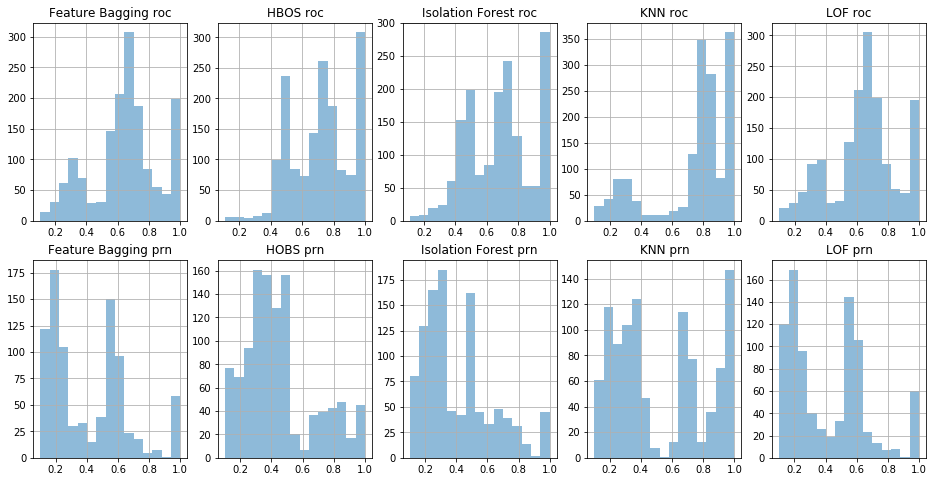

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
#直方图
plt.subplot(2,5,1)
plt.title("Feature Bagging roc")
roc['Feature Bagging'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,2)
plt.title("HBOS roc")
roc['Histogram-base Outlier Detection (HBOS)'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,3)
plt.title("Isolation Forest roc")
roc['Isolation Forest'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,4)
plt.title("KNN roc")
roc['K Nearest Neighbors (KNN)'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,5)
plt.title("LOF roc")
roc['Local Outlier Factor (LOF)'].hist(alpha=0.5,bins=15)

plt.subplot(2,5,6)
plt.title("Feature Bagging prn")
rank_n['Feature Bagging'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,7)
plt.title("HOBS prn")
rank_n['Histogram-base Outlier Detection (HBOS)'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,8)
plt.title("Isolation Forest prn")
rank_n['Isolation Forest'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,9)
plt.title("KNN prn")
rank_n['K Nearest Neighbors (KNN)'].hist(alpha=0.5,bins=15)
plt.subplot(2,5,10)
plt.title("LOF prn")
rank_n['Local Outlier Factor (LOF)'].hist(alpha=0.5,bins=15)